## End-to-end Medical X-Ray Imaging: Pneumonia Detection Project

#1. Problem

Identifying images of thorax that present Pneumonia from a set of images from healthy patients, and patiens that present the disease.

#2. Data

From Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

#3. Evaluation

A file with prediction probabilities for each thorax test image


# Features
We're dealing with images (unstructured data) so it's probably best we euse deep learning/transferr learning.

* We have two clear classes: Healthy and Pneumonia
* There are around 1000+ images in the training set (these images have labels-Normal and Pneumonia)
*There are around 1000+ images in the test set



In [1]:
#Mount drive to hac¿ve access to our data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get our worksapce ready

* Import Tensowrflow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU


In [2]:
# Import TensforFlow into Collab
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [3]:
!unzip "/content/drive/MyDrive/Pneumonia_Project/archive_2.zip" -d "/content/drive/MyDrive/Pneumonia_Project"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bacteria/person1268_bacteria_3228.jpeg  
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bacteria/person1269_bacteria_3229.jpeg  
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bacteria/person1270_bacteria_3230.jpeg  
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bacteria/person1271_bacteria_3231.jpeg  
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bacteria/person1272_bacteria_3232.jpeg  
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bacteria/person1273_bacteria_3233.jpeg  
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bacteria/person1273_bacteria_3234.jpeg  
  inflating: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/Bact

In [4]:
!pip install --upgrade tf-keras-vis  # Ensure the library is up-to-date
!pip install keras-tuner --upgrade
!pip install tf-keras-vis tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.6 MB/s eta 0:00:00


In [5]:
# Import other necessary tools
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
# Import Gradcam directly from gradcam module
from tf_keras_vis.gradcam import Gradcam
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
import keras_tuner as kt
# Gradcam is already imported above
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
#from tf_keras_vis.utils import get_gradcam
from tqdm import tqdm




In [6]:
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


## Getting our data ready

We'll start with data preprocessing

## Preprocessing the Training set


# Function to create dataset with correct labels based on folder structure


But first we need to place correct labels and store our labels in dataframes so we can process


In [7]:
# Function to create dataset with correct labels based on folder structure
# Function to create dataset with correct labels based on folder structure
def create_dataset(folder_path):
    my_list = []

    # Define the folders and corresponding labels
    class_labels = {
        'NORMAL': 0,    # Label for NORMAL
        'Bacteria': 1,     # Label for Bactetria
        'Virus': 2   # Label for Virus
    }

    # Iterate over each of the three categories: 'NORMAL', 'Virus', 'Bacteria'
    for category in class_labels:
        category_path = os.path.join(folder_path, category)

        if os.path.exists(category_path):
            # For each file in the category folder, assign the corresponding label
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    my_list.append([file_path, class_labels[category]])  # Assign label based on folder

    # Convert the list to a DataFrame
    df = pd.DataFrame(my_list, columns=['file_path', 'label'])
    return df

In [8]:
# Create training and validation datasets
train_folder_path = '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train'
train_df = create_dataset(train_folder_path)

In [9]:
# Print the first few rows to confirm label assignment
print("Original labels:", train_df.head())

Original labels:                                            file_path  label
0  /content/drive/MyDrive/Pneumonia_Project/archi...      0
1  /content/drive/MyDrive/Pneumonia_Project/archi...      0
2  /content/drive/MyDrive/Pneumonia_Project/archi...      0
3  /content/drive/MyDrive/Pneumonia_Project/archi...      0
4  /content/drive/MyDrive/Pneumonia_Project/archi...      0


In [10]:
# Check the distribution of labels before one-hot encoding
print("Label distribution before one-hot encoding:")
print(train_df['label'].value_counts())  # This should show counts for 0, 1, and 2




Label distribution before one-hot encoding:
label
1    2530
2    1345
0    1341
Name: count, dtype: int64


In [11]:
#Image augmentation so the model doesn't overfit, we augment the diversity of the training set images.

# Set Up the ImageDataGenerator for Augment
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
# Define the target image size
target_size = (150, 150)

import os

# Define the folder path
train_folder_path = "/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train"

# We are adding a prefix (e.g., 0_, 1_, 2_) to the folder names to force the correct alphabetical order
class_order = {
    'NORMAL': '0_NORMAL',
    'Bacteria': '1_Bacteria',
    'Virus': '2_Virus'
}

# Loop through the directories and rename them
for original_class, new_class in class_order.items():
    original_path = os.path.join(train_folder_path, original_class)
    new_path = os.path.join(train_folder_path, new_class)

    if os.path.exists(original_path):
        os.rename(original_path, new_path)
        print(f"Renamed '{original_class}' to '{new_class}'")
    else:
        print(f"Error: {original_class} folder not found")

# Now use flow_from_directory
train_set = train_datagen.flow_from_directory(
    train_folder_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
)

# Print out the classes detected
print("Classes detected:", train_set.class_indices)








Error: NORMAL folder not found
Error: Bacteria folder not found
Error: Virus folder not found
Found 5216 images belonging to 3 classes.
Classes detected: {'0_NORMAL': 0, '1_Bacteria': 1, '2_Virus': 2}


In [14]:
# Calculate class weights based on class imbalance
class_weights = {0: 0., 1: 1., 2: 2.}  # Adjust weights for imbalance

# Check images in each renamed folder
for category, folder_prefix in zip(['NORMAL', 'Bacteria', 'Virus'], ['0_NORMAL', '1_Bacteria', '2_Virus']):
    category_path = os.path.join(train_folder_path, folder_prefix)  # Use the renamed folder name
    if os.path.exists(category_path):
        # List only valid image files
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Images in {category}: {len(image_files)}")


Images in NORMAL: 1341
Images in Bacteria: 2530
Images in Virus: 1345


So what's going on with the code above?

When we apply all these transoformations, we are helping our data be ready for the model. But why would we use what we used?

🎩 **Well, the answer is actually very straightforward but somewhat magical:**

* 🧮 Scaling the pixel values to 0-1: We make the pixel values go from 0 to 255
  (basically the full color range) to a nice, tidy range of 0 to 1. This helps the model learn faster and more efficiently! 🚀 In other words, it just performs better!

* 🔄 Rotating the image up to 40 degrees: We let the image spin around a
  little, which helps the model recognize the object, no matter which direction it’s turned. So if your image is rotated in real life, the model won’t be confused!

* ➡️ Shifting the image horizontally: We randomly move the image left or right
  (up to 20% of the image width). This teaches the model to focus on the object itself, not just where it’s located in the frame. It’s about object recognition, not positioning!

* ⬆️ Shifting the image vertically: Just like with horizontal shifting, we also
  move the image up or down (20% of the height). This makes the model more flexible and teaches it to recognize the object, no matter where it is vertically in the image!

* ✂️ Shearing: We introduce a bit of distortion, like stretching the image a
  little. This helps the model understand that objects can look a bit different in real life—nothing is always perfectly aligned!

* 🔍 Zooming in or out: We let the image zoom in or out (by 20%), which helps
  the model adapt to different object sizes. Sometimes the object is far away, sometimes it's close—it’ll handle both!

**Now, what else?**

* ↔️ Flipping horizontally: We flip the image like we’re giving it a mirror c
  check! This helps the model recognize objects even if they’re flipped, teaching it to understand that the object can appear from different angles.

* 📏 Filling any empty space: Sometimes, after transforming the image (like
  rotating or shifting), there can be empty areas. We fill those areas with the nearest pixel values, keeping the image looking smooth and intact—no awkward gaps!

So, in a nutshell: Rotation, shifting, shearing, zooming, flipping, and filling all come together to make the model more flexible, more robust, and more adaptable to all sorts of real-world scenarios. We want it to be super smart and not just memorize the exact positions of objects—it should be able to recognize the object no matter how it’s presented! 🎯✨

Now that we see that our code worked for a few samples, let's make data augmentation for our entire train dataset, so we can save it and use it in our model later on.

## Preprocessing of the test dataset

**Key Differences for Test Set:**

No Augmentation: For the test set, we only rescale the pixel values. We don't apply any other transformations (like rotations, shifts, etc.) because we want to evaluate the model on the raw, unaltered test images.

Rescaling: We rescale the test images in the same way as the training images to ensure consistency, so the model can make predictions based on data in the same format.

Recap of What’s Happening:
Training Set: Augmentation (rotation, zoom, etc.) + rescaling.
Test Set: Only rescaling to ensure the model is tested on real-world, unaltered data.
This way, the test set remains consistent with the actual data the model will encounter in production, and it’ll give you a more accurate evaluation. 😊

In [17]:
# Create Dataset function for Test set

def create_dataset(folder_path):
    my_list = []

    # Define the folders and corresponding labels
    class_labels = {
        'NORMAL': 0,    # Label for NORMAL
        'Bacteria': 1,  # Label for Bacteria
        'Virus': 2      # Label for Virus
    }

    # Iterate over each of the three categories: 'NORMAL', 'Virus', 'Bacteria'
    for category, label in class_labels.items():
        category_path = os.path.join(folder_path, category)

        if os.path.exists(category_path):
            # For each file in the category folder, assign the corresponding label
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    my_list.append([file_path, label])  # Assign label based on folder

    # Convert the list to a DataFrame
    df = pd.DataFrame(my_list, columns=['file_path', 'label'])
    return df

# Create test dataset
test_folder_path = '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test'
test_df = create_dataset(test_folder_path)

# One-hot encode the test labels
test_df = pd.get_dummies(test_df, columns=['label'], prefix='label')

# Rename columns according to the label names
test_df.rename(columns={'label_0': 'Normal', 'label_1': 'Bacteria', 'label_2': 'Virus'}, inplace=True)

# Initialize ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the flow_from_dataframe for test dataset
test_set = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # Images are already referenced by 'file_path'
    x_col='file_path',
    y_col=['Normal', 'Bacteria', 'Virus'],  # Provide the one-hot encoded columns here
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',# Changed class_mode to raw to handle numerical y_col
    shuffle=False
)



Found 624 validated image filenames.


In [18]:
# Show the first few rows of the test dataframe to see the labels in 'Normal', 'Bacteria', 'Virus'
print(test_df[['Normal', 'Bacteria', 'Virus']].head())

# If you want to see the unique values in each column (for each class)
print("Unique values for each class:")
print("Normal:", test_df['Normal'].unique())
print("Bacteria:", test_df['Bacteria'].unique())
print("Virus:", test_df['Virus'].unique())


   Normal  Bacteria  Virus
0    True     False  False
1    True     False  False
2    True     False  False
3    True     False  False
4    True     False  False
Unique values for each class:
Normal: [ True False]
Bacteria: [False  True]
Virus: [False  True]


## Building the CNN

* Initialising the CNN:
  1. Convolution
  2. Pooling
  3. Flattening
  4. Full Connection
  5. Output layer


# 1. Initialising the CNN

In [ ]:
# Build the CNN model
cnn = Sequential()

## Convolution

In [ ]:
# Convolution layer
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 2. Pooling

In [ ]:
cnn.add(MaxPooling2D(pool_size=2, strides=2))

# Adding a second convolutional layer

In [ ]:
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2))

# 3. Flattening

In [ ]:
# Flattening layer
cnn.add(Flatten())

# 4. Full connection

In [ ]:
# Fully connected layer
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(0.5))  # Dropout to prevent overfitting

# 5. Output layer

In [ ]:
# Output Layer for classification (in this sparticular case 3 classes: Normal, Bacteria, Virus--remember bacteria and virus account for Pneumonia)
cnn.add(Dense(3, activation='softmax')) #-- remember we are using softmax because we have more than two classes. If you are using binary, make sure to use a sigmoid activation

## Training the CNN

 We need to compile first! Compiling helps on:

1. How the model will learn (i.e., which optimizer to use).
2. How it will measure progress during training (i.e., which loss function to  
   use).
3. How we’ll evaluate performance (i.e., which metrics to track, like accuracy).

In [ ]:
# Compiling the CNN

""" The optimizer is like the "brain" of your model. It helps the model adjust its weights based on the error or difference between the predicted output and the actual output.
    The loss function tells the model how wrong it was in its prediction. Since we have multiple categories, we'll use categorical_crossentropy.
    Metrics like accuracy are used to track how well your model is doing during training. For a classification task, we care about how many of the model's predictions match the correct label.
"""
cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.utils import class_weight
# Class weighting to deal with imbalanced classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)


## Training the CNN on the Training set and evaluating it on the Test Set

In [ ]:
# Train the model
cnn.fit(
    x=train_set,
    validation_data=test_set,
    epochs=25,
    class_weight={i: class_weights[i] for i in range(3)}  # Apply class weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 721ms/step - accuracy: 0.4410 - loss: 1.5214 - val_accuracy: 0.5016 - val_loss: 1.0851
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 714ms/step - accuracy: 0.5986 - loss: 0.9217 - val_accuracy: 0.6779 - val_loss: 0.8815
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 712ms/step - accuracy: 0.6217 - loss: 0.8624 - val_accuracy: 0.6603 - val_loss: 0.8521
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 719ms/step - accuracy: 0.6303 - loss: 0.8326 - val_accuracy: 0.7115 - val_loss: 0.7901
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 705ms/step - accuracy: 0.6563 - loss: 0.7926 - val_accuracy: 0.7179 - val_loss: 0.8043
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 707ms/step - accuracy: 0.6565 - loss: 0.7775 - val_accuracy: 0.6939 - val_loss: 0.8593
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 703ms/step - accuracy: 0.6785 - loss: 0.7516 - val_accuracy: 0.7099 - val_loss: 0.7526
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 689ms/step - accuracy: 0.6855 -

## Making a single prediction

In [ ]:
# Make a single prediction
from keras.preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0001-0001.jpeg', target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = cnn.predict(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


In [ ]:
# Map predictions back to classes
class_names = ['Normal', 'Bacteria', 'Virus']
prediction = class_names[np.argmax(result)]
print(prediction)

Normal


In [ ]:
test_image = image.load_img('/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_478.jpeg', target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = cnn.predict(test_image)

# Map predictions back to classes
class_names = ['Normal', 'Bacteria', 'Virus']
prediction = class_names[np.argmax(result)]
print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Normal


In [ ]:
# Now that we see that our code has worked in one image, let's try it for the rest of the test images

# Get a list of all image file paths in the test folder
test_folder = '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test'
image_paths = []
for root, dirs, files in os.walk(test_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Loop through the images and make predictions
for img_path in tqdm(image_paths):  # Use tqdm to display a progress bar
    # Load and preprocess the image
    test_image = image.load_img(img_path, target_size=(150, 150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    # Make the prediction
    result = cnn.predict(test_image)

    # Determine the predicted class (Assuming class indices are 0: Normal, 1: Bacteria, 2: Virus)
    prediction = class_names[np.argmax(result)]

    # Print the image path and the prediction
    print(f"Image: {img_path} - Prediction: {prediction}")



  0%|          | 0/624 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  0%|          | 1/624 [00:00<01:48,  5.73it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0001-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  0%|          | 2/624 [00:00<01:54,  5.42it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0003-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  0%|          | 3/624 [00:00<03:17,  3.15it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0005-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  1%|          | 4/624 [00:01<04:04,  2.53it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0006-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  1%|          | 5/624 [00:01<03:13,  3.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0007-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|          | 6/624 [00:01<02:37,  3.92it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0009-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  1%|          | 7/624 [00:01<02:15,  4.55it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0010-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  1%|▏         | 8/624 [00:02<02:11,  4.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0011-0001.jpeg - Prediction: Normal

  1%|▏         | 9/624 [00:02<01:58,  5.19it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  2%|▏         | 10/624 [00:02<01:56,  5.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  2%|▏         | 11/624 [00:02<01:52,  5.46it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0013-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  2%|▏         | 12/624 [00:02<01:50,  5.56it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0015-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  2%|▏         | 13/624 [00:02<01:57,  5.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0016-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  2%|▏         | 14/624 [00:03<01:55,  5.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0017-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  2%|▏         | 15/624 [00:03<01:47,  5.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0019-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|▎         | 16/624 [00:03<01:54,  5.31it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0021-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 17/624 [00:03<01:53,  5.35it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0025-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 18/624 [00:03<01:39,  6.08it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0023-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 19/624 [00:03<01:41,  5.97it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0029-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|▎         | 20/624 [00:04<01:38,  6.14it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0027-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 21/624 [00:04<01:29,  6.71it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0028-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|▎         | 22/624 [00:04<01:25,  7.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0022-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0030-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|▍         | 24/624 [00:04<01:20,  7.42it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0031-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  4%|▍         | 25/624 [00:04<01:28,  6.74it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0033-0001-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  4%|▍         | 26/624 [00:04<01:32,  6.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0033-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  4%|▍         | 27/624 [00:05<01:40,  5.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0033-0001-0002.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 28/624 [00:05<01:42,  5.83it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0036-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▍         | 29/624 [00:05<01:36,  6.14it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0037-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▍         | 30/624 [00:05<01:35,  6.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0035-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 31/624 [00:05<01:33,  6.37it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0041-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  5%|▌         | 32/624 [00:05<01:32,  6.43it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0039-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 33/624 [00:06<01:30,  6.54it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0043-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▌         | 34/624 [00:06<01:25,  6.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0045-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 35/624 [00:06<01:17,  7.62it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0046-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 36/624 [00:06<01:16,  7.66it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0049-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 37/624 [00:06<01:16,  7.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0059-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 38/624 [00:06<01:13,  7.95it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0061-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▋         | 39/624 [00:06<01:17,  7.56it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0050-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▋         | 40/624 [00:06<01:18,  7.41it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0063-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 41/624 [00:07<01:19,  7.34it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0067-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 42/624 [00:07<01:21,  7.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0065-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0069-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 44/624 [00:07<01:10,  8.18it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0070-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 45/624 [00:07<01:14,  7.78it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0071-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0073-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 47/624 [00:07<01:10,  8.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0077-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 48/624 [00:07<01:11,  8.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0075-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 49/624 [00:08<01:13,  7.79it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0079-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 50/624 [00:08<01:14,  7.76it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0081-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 51/624 [00:08<01:13,  7.79it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0083-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0084-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 53/624 [00:08<01:09,  8.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0085-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 54/624 [00:08<01:06,  8.51it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0086-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 55/624 [00:08<01:09,  8.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0087-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 56/624 [00:08<01:12,  7.78it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0089-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  9%|▉         | 57/624 [00:09<01:14,  7.62it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0091-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 58/624 [00:09<01:14,  7.56it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0093-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 59/624 [00:09<01:15,  7.52it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0095-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0097-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 61/624 [00:09<01:04,  8.75it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0099-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0101-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 63/624 [00:09<01:03,  8.89it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0102-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 64/624 [00:09<01:08,  8.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0103-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 65/624 [00:10<01:10,  7.92it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0105-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 66/624 [00:10<01:12,  7.69it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0107-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 67/624 [00:10<01:16,  7.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0109-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 68/624 [00:10<01:15,  7.32it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0110-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 69/624 [00:10<01:15,  7.31it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0111-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 70/624 [00:10<01:16,  7.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0007-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 71/624 [00:10<01:18,  7.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0012-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 72/624 [00:11<01:18,  7.06it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0013-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 73/624 [00:11<01:18,  7.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0019-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 74/624 [00:11<01:20,  6.85it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0023-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 75/624 [00:11<01:20,  6.80it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0028-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 76/624 [00:11<01:17,  7.10it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0030-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 77/624 [00:11<01:12,  7.57it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0027-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▎        | 78/624 [00:11<01:09,  7.84it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0029-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 79/624 [00:11<01:07,  8.06it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0033-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 80/624 [00:12<01:03,  8.55it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0035-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 81/624 [00:12<01:06,  8.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0041-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 13%|█▎        | 82/624 [00:12<01:04,  8.37it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0045-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 83/624 [00:12<01:07,  8.00it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0051-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 84/624 [00:12<01:05,  8.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0052-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▎        | 85/624 [00:12<01:03,  8.52it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0059-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 86/624 [00:12<01:05,  8.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0058-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 87/624 [00:12<01:03,  8.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0060-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 88/624 [00:13<01:07,  7.88it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0066-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▍        | 89/624 [00:13<01:06,  8.09it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0072-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 90/624 [00:13<01:05,  8.15it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0073-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 91/624 [00:13<01:06,  8.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0081-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 15%|█▍        | 92/624 [00:13<01:16,  6.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0079-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 15%|█▍        | 93/624 [00:13<01:23,  6.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0086-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 15%|█▌        | 94/624 [00:14<01:28,  6.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0095-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▌        | 95/624 [00:14<01:25,  6.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0092-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▌        | 96/624 [00:14<01:28,  5.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0096-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 97/624 [00:14<01:27,  6.00it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0098-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 98/624 [00:14<01:30,  5.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0105-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 99/624 [00:14<01:40,  5.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0107-0001.jpeg - Prediction: Normal

 16%|█▌        | 100/624 [00:15<01:32,  5.64it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 16%|█▌        | 101/624 [00:15<01:34,  5.56it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0110-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 16%|█▋        | 102/624 [00:15<01:37,  5.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0112-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 17%|█▋        | 103/624 [00:15<01:34,  5.49it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0111-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 17%|█▋        | 104/624 [00:15<01:28,  5.85it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0117-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 105/624 [00:15<01:25,  6.06it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0120-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 17%|█▋        | 106/624 [00:16<01:26,  6.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0123-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 107/624 [00:16<01:24,  6.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0129-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 17%|█▋        | 108/624 [00:16<01:26,  5.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0130-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 109/624 [00:16<01:28,  5.79it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0132-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0131-0001.jpeg - Prediction: Normal

 18%|█▊        | 110/624 [00:16<01:28,  5.82it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 111/624 [00:16<01:24,  6.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0139-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 112/624 [00:17<01:25,  6.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0141-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 113/624 [00:17<01:27,  5.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0135-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 114/624 [00:17<01:18,  6.49it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0145-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 115/624 [00:17<01:12,  7.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0146-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▊        | 116/624 [00:17<01:11,  7.06it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0150-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 117/624 [00:17<01:07,  7.53it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0171-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▉        | 118/624 [00:17<01:10,  7.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 119/624 [00:18<01:09,  7.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0002.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 120/624 [00:18<01:08,  7.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0195-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 121/624 [00:18<01:03,  7.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0196-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 122/624 [00:18<01:05,  7.66it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0198-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 123/624 [00:18<01:05,  7.62it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0199-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0207-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 125/624 [00:18<01:02,  8.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0206-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 126/624 [00:18<00:59,  8.34it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0210-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 127/624 [00:19<00:58,  8.55it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0201-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 128/624 [00:19<01:01,  8.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0213-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0217-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 130/624 [00:19<00:55,  8.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0221-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 131/624 [00:19<00:55,  8.90it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██        | 132/624 [00:19<00:54,  8.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0222-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██▏       | 133/624 [00:19<00:53,  9.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0232-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██▏       | 134/624 [00:19<00:57,  8.58it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0233-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0237-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 136/624 [00:20<00:56,  8.61it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0238-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 137/624 [00:20<00:55,  8.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0219-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 138/624 [00:20<00:53,  9.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0241-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 139/624 [00:20<00:53,  9.08it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 140/624 [00:20<00:57,  8.48it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 141/624 [00:20<00:58,  8.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 142/624 [00:20<00:59,  8.08it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0249-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 143/624 [00:20<00:58,  8.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0251-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 144/624 [00:21<01:00,  7.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0252-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 145/624 [00:21<01:01,  7.78it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0259-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0271-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 147/624 [00:21<00:54,  8.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0267-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▎       | 148/624 [00:21<00:56,  8.37it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 149/624 [00:21<00:59,  7.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0273-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 150/624 [00:21<01:01,  7.76it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0256-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 151/624 [00:21<01:05,  7.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0274-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 152/624 [00:22<01:00,  7.83it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0275-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 153/624 [00:22<00:56,  8.33it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0276-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 154/624 [00:22<00:58,  8.03it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0277-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 155/624 [00:22<00:59,  7.85it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0278-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0280-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 157/624 [00:22<00:56,  8.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0282-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 158/624 [00:22<01:00,  7.74it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0281-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 159/624 [00:22<00:58,  7.92it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0283-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0285-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 161/624 [00:23<00:57,  8.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0286-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 162/624 [00:23<00:58,  7.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0288-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 163/624 [00:23<01:02,  7.42it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0287-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 164/624 [00:23<00:58,  7.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0289-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 165/624 [00:23<00:55,  8.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0279-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|██▋       | 166/624 [00:23<00:54,  8.48it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0290-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 167/624 [00:23<00:57,  7.89it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0294-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 168/624 [00:24<00:57,  7.89it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0292-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 169/624 [00:24<00:54,  8.33it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0297-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 170/624 [00:24<00:51,  8.75it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0300-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 171/624 [00:24<00:53,  8.41it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0301-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 172/624 [00:24<00:51,  8.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0303-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 173/624 [00:24<00:50,  8.85it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0304-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 174/624 [00:24<00:54,  8.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0305-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 175/624 [00:24<01:00,  7.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0302-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 176/624 [00:24<00:55,  8.00it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0307-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 177/624 [00:25<00:58,  7.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0309-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▊       | 178/624 [00:25<00:59,  7.47it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0311-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0310-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 180/624 [00:25<00:53,  8.37it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0312-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 181/624 [00:25<00:54,  8.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0315-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▉       | 182/624 [00:25<01:00,  7.31it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0313-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 29%|██▉       | 183/624 [00:25<01:08,  6.47it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0316-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██▉       | 184/624 [00:26<01:09,  6.35it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0317-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 30%|██▉       | 185/624 [00:26<01:14,  5.90it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0321-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|██▉       | 186/624 [00:26<01:14,  5.87it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0319-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 187/624 [00:26<01:10,  6.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0322-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 188/624 [00:26<01:04,  6.80it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0323-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 189/624 [00:26<01:04,  6.69it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0325-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 190/624 [00:27<00:59,  7.35it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0326-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 191/624 [00:27<00:58,  7.37it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0327-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███       | 192/624 [00:27<00:58,  7.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0328-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|███       | 193/624 [00:27<01:03,  6.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0329-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 31%|███       | 194/624 [00:27<01:05,  6.56it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0330-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 31%|███▏      | 195/624 [00:27<01:04,  6.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0331-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 31%|███▏      | 196/624 [00:27<01:08,  6.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0332-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 32%|███▏      | 197/624 [00:28<01:13,  5.80it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0333-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 32%|███▏      | 198/624 [00:28<01:20,  5.32it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0335-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 32%|███▏      | 199/624 [00:28<01:14,  5.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0336-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 32%|███▏      | 200/624 [00:28<01:16,  5.56it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0337-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 201/624 [00:28<01:12,  5.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0338-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 32%|███▏      | 202/624 [00:29<01:14,  5.69it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0339-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 203/624 [00:29<01:09,  6.05it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0340-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 204/624 [00:29<01:09,  6.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0341-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 33%|███▎      | 205/624 [00:29<01:07,  6.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0343-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 33%|███▎      | 206/624 [00:29<01:07,  6.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0346-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 33%|███▎      | 207/624 [00:29<01:10,  5.90it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0345-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 33%|███▎      | 208/624 [00:30<01:08,  6.03it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0347-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 209/624 [00:30<01:08,  6.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0349-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 34%|███▎      | 210/624 [00:30<01:09,  6.00it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0348-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 34%|███▍      | 211/624 [00:30<01:08,  5.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0351-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 34%|███▍      | 212/624 [00:30<01:11,  5.76it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0350-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|███▍      | 213/624 [00:30<01:12,  5.64it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0352-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 34%|███▍      | 214/624 [00:31<01:12,  5.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0353-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 34%|███▍      | 215/624 [00:31<01:11,  5.72it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0354-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 216/624 [00:31<01:07,  6.03it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0357-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 217/624 [00:31<01:04,  6.34it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0359-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 218/624 [00:31<01:00,  6.69it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0360-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 219/624 [00:31<00:59,  6.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0361-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 220/624 [00:31<00:58,  6.91it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0362-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 221/624 [00:32<00:53,  7.49it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0364-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 222/624 [00:32<00:55,  7.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0366-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 223/624 [00:32<00:51,  7.75it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0368-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 224/624 [00:32<00:52,  7.60it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0369-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 225/624 [00:32<00:49,  8.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0370-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 226/624 [00:32<00:48,  8.18it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0372-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▋      | 227/624 [00:32<00:54,  7.29it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0374-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 228/624 [00:32<00:54,  7.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0374-0001-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 229/624 [00:33<00:53,  7.32it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0374-0001-0002.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 230/624 [00:33<00:50,  7.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0373-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0376-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 232/624 [00:33<00:47,  8.30it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0378-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 233/624 [00:33<00:49,  7.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 234/624 [00:33<00:47,  8.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/NORMAL2-IM-0381-0001.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 235/624 [00:33<00:46,  8.38it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1_virus_11.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 38%|███▊      | 236/624 [00:33<00:45,  8.51it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1_virus_12.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1_virus_6.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 238/624 [00:34<00:44,  8.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1_virus_13.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 239/624 [00:34<00:44,  8.72it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1_virus_7.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 240/624 [00:34<00:42,  9.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1_virus_8.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1_virus_9.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 242/624 [00:34<00:39,  9.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person10_virus_35.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 243/624 [00:34<00:42,  9.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person11_virus_38.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▉      | 244/624 [00:34<00:42,  9.00it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person15_virus_46.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 245/624 [00:34<00:45,  8.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1608_virus_2786.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▉      | 246/624 [00:35<00:46,  8.19it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person16_virus_47.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 40%|███▉      | 247/624 [00:35<01:04,  5.84it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1612_virus_2797.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 248/624 [00:35<00:57,  6.52it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1610_virus_2793.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 249/624 [00:35<00:52,  7.10it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person14_virus_44.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1612_virus_2798.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 251/624 [00:35<00:47,  7.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1613_virus_2799.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 252/624 [00:35<00:44,  8.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1614_virus_2800.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 253/624 [00:36<00:46,  7.90it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1615_virus_2801.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 254/624 [00:36<00:47,  7.76it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1616_virus_2802.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 255/624 [00:36<00:48,  7.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1618_virus_2805.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1619_virus_2806.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 257/624 [00:36<00:45,  8.10it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1622_virus_2810.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████▏     | 258/624 [00:36<00:43,  8.39it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1620_virus_2807.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 259/624 [00:36<00:45,  7.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1623_virus_2813.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 260/624 [00:36<00:47,  7.69it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1625_virus_2817.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 261/624 [00:37<00:45,  8.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1626_virus_2818.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 262/624 [00:37<00:46,  7.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1627_virus_2819.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 263/624 [00:37<00:44,  8.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1628_virus_2821.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 264/624 [00:37<00:45,  7.84it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1629_virus_2823.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 265/624 [00:37<00:46,  7.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1631_virus_2826.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1628_virus_2822.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 267/624 [00:37<00:44,  8.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1632_virus_2827.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 268/624 [00:37<00:42,  8.35it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1634_virus_2830.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 269/624 [00:38<00:44,  7.97it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1635_virus_2831.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 270/624 [00:38<00:45,  7.76it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1637_virus_2834.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 271/624 [00:38<00:46,  7.61it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1633_virus_2829.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▎     | 272/624 [00:38<00:47,  7.40it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1641_virus_2840.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 273/624 [00:38<00:48,  7.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1642_virus_2842.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 274/624 [00:38<00:48,  7.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1640_virus_2839.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 275/624 [00:38<00:49,  7.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1644_virus_2844.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 276/624 [00:39<00:49,  7.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1643_virus_2843.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 277/624 [00:39<00:49,  7.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1647_virus_2848.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 278/624 [00:39<00:47,  7.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1645_virus_2845.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▍     | 279/624 [00:39<00:48,  7.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1649_virus_2850.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 280/624 [00:39<00:47,  7.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1650_virus_2852.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 281/624 [00:39<00:47,  7.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1650_virus_2854.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▌     | 282/624 [00:39<00:48,  7.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1653_virus_2858.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 283/624 [00:40<00:47,  7.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1651_virus_2855.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 284/624 [00:40<00:47,  7.14it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1655_virus_2861.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 285/624 [00:40<00:47,  7.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1653_virus_2859.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 286/624 [00:40<00:46,  7.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1656_virus_2862.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 287/624 [00:40<00:46,  7.19it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1657_virus_2864.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 288/624 [00:40<00:45,  7.30it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1659_virus_2867.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▋     | 289/624 [00:40<00:42,  7.83it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1660_virus_2869.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 290/624 [00:40<00:43,  7.62it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1661_virus_2873.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 291/624 [00:41<00:44,  7.48it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1661_virus_2872.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 292/624 [00:41<00:42,  7.90it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1662_virus_2875.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 47%|████▋     | 293/624 [00:41<00:47,  6.98it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1663_virus_2876.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 47%|████▋     | 294/624 [00:41<00:48,  6.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1665_virus_2878.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 47%|████▋     | 295/624 [00:41<00:49,  6.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1664_virus_2877.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 47%|████▋     | 296/624 [00:41<00:48,  6.79it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1667_virus_2881.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|████▊     | 297/624 [00:42<00:49,  6.64it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1668_virus_2882.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 298/624 [00:42<00:48,  6.75it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1669_virus_2885.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 48%|████▊     | 299/624 [00:42<00:48,  6.66it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1670_virus_2886.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 300/624 [00:42<00:48,  6.71it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1669_virus_2884.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 48%|████▊     | 301/624 [00:42<00:49,  6.52it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1671_virus_2887.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 48%|████▊     | 302/624 [00:42<00:52,  6.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1672_virus_2888.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 49%|████▊     | 303/624 [00:42<00:50,  6.30it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1673_virus_2889.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▊     | 304/624 [00:43<00:52,  6.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1674_virus_2890.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 49%|████▉     | 305/624 [00:43<00:51,  6.25it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1675_virus_2891.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 49%|████▉     | 306/624 [00:43<00:50,  6.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1676_virus_2892.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 49%|████▉     | 307/624 [00:43<00:50,  6.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1679_virus_2896.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▉     | 308/624 [00:43<00:51,  6.09it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1678_virus_2895.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 309/624 [00:43<00:52,  6.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1680_virus_2897.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|████▉     | 310/624 [00:44<00:51,  6.10it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1685_virus_2903.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|████▉     | 311/624 [00:44<00:49,  6.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person17_virus_48.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|█████     | 312/624 [00:44<00:50,  6.15it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person1682_virus_2899.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|█████     | 313/624 [00:44<00:50,  6.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person18_virus_49.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 50%|█████     | 314/624 [00:44<00:50,  6.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person20_virus_51.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 315/624 [00:44<00:50,  6.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person19_virus_50.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 51%|█████     | 316/624 [00:45<00:53,  5.78it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person21_virus_52.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 51%|█████     | 317/624 [00:45<00:54,  5.59it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person21_virus_53.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 318/624 [00:45<00:50,  6.08it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person22_virus_54.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 319/624 [00:45<00:47,  6.43it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person23_virus_56.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████▏    | 320/624 [00:45<00:45,  6.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person22_virus_55.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████▏    | 321/624 [00:45<00:45,  6.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person25_virus_59.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 322/624 [00:45<00:44,  6.80it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person28_virus_62.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 323/624 [00:46<00:43,  6.96it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person26_virus_60.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 324/624 [00:46<00:39,  7.58it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person24_virus_58.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 325/624 [00:46<00:39,  7.50it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person28_virus_63.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person29_virus_64.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 327/624 [00:46<00:36,  8.03it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person3_virus_15.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 328/624 [00:46<00:37,  7.89it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person3_virus_16.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 329/624 [00:46<00:38,  7.66it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person30_virus_69.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 330/624 [00:47<00:39,  7.51it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person31_virus_70.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 331/624 [00:47<00:39,  7.39it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person3_virus_17.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 332/624 [00:47<00:37,  7.88it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person33_virus_72.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 333/624 [00:47<00:34,  8.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person32_virus_71.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▎    | 334/624 [00:47<00:36,  7.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person35_virus_80.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 335/624 [00:47<00:37,  7.62it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person34_virus_76.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 336/624 [00:47<00:38,  7.49it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person36_virus_81.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 337/624 [00:47<00:37,  7.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person37_virus_82.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 338/624 [00:48<00:34,  8.21it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person38_virus_83.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person38_virus_84.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 340/624 [00:48<00:33,  8.56it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person39_virus_85.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 341/624 [00:48<00:32,  8.78it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person40_virus_87.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 342/624 [00:48<00:34,  8.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person41_virus_88.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person42_virus_89.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 344/624 [00:48<00:33,  8.35it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person43_virus_92.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▌    | 345/624 [00:48<00:35,  7.97it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person45_virus_95.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 346/624 [00:48<00:35,  7.76it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person44_virus_93.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 347/624 [00:49<00:36,  7.60it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person44_virus_94.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 348/624 [00:49<00:34,  8.05it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person47_virus_99.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 349/624 [00:49<00:35,  7.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person48_virus_100.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 350/624 [00:49<00:34,  7.84it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person46_virus_96.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 351/624 [00:49<00:33,  8.19it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person49_virus_101.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▋    | 352/624 [00:49<00:34,  7.96it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person51_virus_105.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 353/624 [00:49<00:34,  7.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person50_virus_102.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 354/624 [00:49<00:33,  8.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person52_virus_106.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 355/624 [00:50<00:34,  7.88it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person53_virus_107.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 356/624 [00:50<00:34,  7.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person53_virus_108.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 357/624 [00:50<00:35,  7.60it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person54_virus_109.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 358/624 [00:50<00:35,  7.51it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person55_virus_110.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 359/624 [00:50<00:32,  8.09it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person56_virus_112.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 360/624 [00:50<00:31,  8.48it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person57_virus_113.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|█████▊    | 361/624 [00:50<00:33,  7.97it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person59_virus_116.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 362/624 [00:51<00:34,  7.57it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person60_virus_117.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person61_virus_118.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 364/624 [00:51<00:30,  8.49it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person63_virus_121.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 365/624 [00:51<00:32,  8.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person62_virus_119.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person65_virus_123.jpeg - Prediction: Normal


 59%|█████▊    | 366/624 [00:51<00:33,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 367/624 [00:51<00:31,  8.13it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person64_virus_122.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 368/624 [00:51<00:30,  8.49it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person66_virus_125.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 59%|█████▉    | 369/624 [00:51<00:32,  7.95it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person69_virus_129.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 370/624 [00:52<00:33,  7.48it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person67_virus_126.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 371/624 [00:52<00:34,  7.33it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person70_virus_130.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 372/624 [00:52<00:34,  7.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person71_virus_132.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 373/624 [00:52<00:34,  7.30it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person74_virus_135.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 374/624 [00:52<00:34,  7.31it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person72_virus_133.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 375/624 [00:52<00:34,  7.32it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person71_virus_131.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|██████    | 376/624 [00:52<00:33,  7.31it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person75_virus_136.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 377/624 [00:52<00:32,  7.64it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person76_virus_138.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 378/624 [00:53<00:31,  7.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person77_virus_139.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 379/624 [00:53<00:32,  7.46it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person79_virus_148.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 380/624 [00:53<00:33,  7.35it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person78_virus_140.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 381/624 [00:53<00:32,  7.38it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person8_virus_27.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 382/624 [00:53<00:30,  8.00it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Virus/person8_virus_28.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 383/624 [00:53<00:28,  8.41it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_475.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████▏   | 384/624 [00:53<00:28,  8.35it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_478.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 385/624 [00:53<00:30,  7.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_477.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 386/624 [00:54<00:31,  7.60it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_479.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_480.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 388/624 [00:54<00:29,  8.10it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_482.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 389/624 [00:54<00:30,  7.76it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person101_bacteria_484.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▎   | 390/624 [00:54<00:30,  7.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_481.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 391/624 [00:54<00:28,  8.19it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person101_bacteria_483.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 392/624 [00:54<00:30,  7.68it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person101_bacteria_485.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 393/624 [00:55<00:30,  7.58it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person101_bacteria_486.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 394/624 [00:55<00:31,  7.34it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person102_bacteria_487.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 395/624 [00:55<00:30,  7.40it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person103_bacteria_488.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 396/624 [00:55<00:30,  7.37it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person103_bacteria_490.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 64%|██████▎   | 397/624 [00:55<00:32,  6.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person104_bacteria_492.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 64%|██████▍   | 398/624 [00:55<00:33,  6.70it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person104_bacteria_491.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|██████▍   | 399/624 [00:55<00:33,  6.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person108_bacteria_504.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 400/624 [00:56<00:33,  6.59it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person103_bacteria_489.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 64%|██████▍   | 401/624 [00:56<00:35,  6.25it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person108_bacteria_506.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 64%|██████▍   | 402/624 [00:56<00:34,  6.40it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person108_bacteria_507.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▍   | 403/624 [00:56<00:34,  6.38it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person108_bacteria_511.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 65%|██████▍   | 404/624 [00:56<00:34,  6.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_513.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 65%|██████▍   | 405/624 [00:56<00:35,  6.18it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_512.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 65%|██████▌   | 406/624 [00:57<00:35,  6.06it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_517.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_519.jpeg - Prediction: Normal


 65%|██████▌   | 407/624 [00:57<00:38,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 408/624 [00:57<00:35,  6.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_522.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████▌   | 409/624 [00:57<00:35,  6.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_523.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████▌   | 410/624 [00:57<00:35,  6.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_526.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 66%|██████▌   | 411/624 [00:57<00:33,  6.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_527.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|██████▌   | 412/624 [00:58<00:31,  6.66it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person110_bacteria_531.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▌   | 413/624 [00:58<00:31,  6.64it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person109_bacteria_528.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 66%|██████▋   | 414/624 [01:35<39:33, 11.30s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person111_bacteria_533.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 67%|██████▋   | 415/624 [01:35<27:44,  7.96s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person111_bacteria_535.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 67%|██████▋   | 416/624 [01:35<19:29,  5.62s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person111_bacteria_534.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 67%|██████▋   | 417/624 [01:35<13:46,  3.99s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person111_bacteria_536.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 67%|██████▋   | 418/624 [01:36<09:45,  2.84s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person111_bacteria_537.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 67%|██████▋   | 419/624 [01:36<06:58,  2.04s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person112_bacteria_539.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 67%|██████▋   | 420/624 [01:36<05:02,  1.48s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person112_bacteria_538.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 421/624 [01:36<03:39,  1.08s/it]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person113_bacteria_540.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 422/624 [01:36<02:39,  1.26it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person113_bacteria_541.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 423/624 [01:36<01:58,  1.69it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person113_bacteria_542.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 424/624 [01:37<01:29,  2.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person113_bacteria_543.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 425/624 [01:37<01:10,  2.83it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person114_bacteria_544.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 426/624 [01:37<00:58,  3.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person114_bacteria_545.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 427/624 [01:37<00:47,  4.15it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person117_bacteria_553.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▊   | 428/624 [01:37<00:39,  4.91it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person117_bacteria_556.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 429/624 [01:37<00:36,  5.37it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person114_bacteria_546.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 430/624 [01:37<00:31,  6.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person118_bacteria_559.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 431/624 [01:37<00:31,  6.19it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person117_bacteria_557.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 432/624 [01:38<00:27,  6.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person118_bacteria_560.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 433/624 [01:38<00:25,  7.51it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person119_bacteria_565.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|██████▉   | 434/624 [01:38<00:26,  7.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person119_bacteria_566.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 435/624 [01:38<00:26,  7.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person119_bacteria_568.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 436/624 [01:38<00:23,  7.85it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person120_bacteria_570.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 437/624 [01:38<00:22,  8.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person119_bacteria_567.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████   | 438/624 [01:38<00:23,  7.95it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person120_bacteria_571.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████   | 439/624 [01:38<00:24,  7.43it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person120_bacteria_573.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 440/624 [01:39<00:23,  7.85it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person121_bacteria_576.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 441/624 [01:39<00:24,  7.60it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person121_bacteria_575.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 442/624 [01:39<00:25,  7.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person120_bacteria_572.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 443/624 [01:39<00:23,  7.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person121_bacteria_578.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 444/624 [01:39<00:23,  7.64it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person121_bacteria_579.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████▏  | 445/624 [01:39<00:23,  7.49it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person121_bacteria_580.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████▏  | 446/624 [01:39<00:24,  7.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person122_bacteria_581.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 447/624 [01:40<00:24,  7.32it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person122_bacteria_582.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 448/624 [01:40<00:23,  7.41it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person122_bacteria_583.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 449/624 [01:40<00:23,  7.39it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person122_bacteria_584.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 450/624 [01:40<00:24,  7.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person122_bacteria_585.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 451/624 [01:40<00:24,  6.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person122_bacteria_586.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 452/624 [01:40<00:24,  7.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person123_bacteria_587.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 453/624 [01:40<00:24,  6.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person124_bacteria_589.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 454/624 [01:41<00:24,  7.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person124_bacteria_590.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 455/624 [01:41<00:23,  7.13it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person124_bacteria_591.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 456/624 [01:41<00:23,  7.13it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person124_bacteria_592.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 457/624 [01:41<00:24,  6.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person125_bacteria_594.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 458/624 [01:41<00:21,  7.64it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person126_bacteria_598.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 459/624 [01:41<00:20,  8.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person125_bacteria_595.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 460/624 [01:41<00:20,  8.00it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person126_bacteria_599.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 461/624 [01:41<00:21,  7.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person126_bacteria_600.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 462/624 [01:42<00:19,  8.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person127_bacteria_603.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 463/624 [01:42<00:20,  7.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person127_bacteria_602.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 464/624 [01:42<00:21,  7.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person127_bacteria_604.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 465/624 [01:42<00:22,  7.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person128_bacteria_607.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 466/624 [01:42<00:20,  7.65it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person128_bacteria_608.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 467/624 [01:42<00:19,  8.05it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person128_bacteria_605.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 468/624 [01:42<00:20,  7.79it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person130_bacteria_623.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 469/624 [01:42<00:20,  7.55it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person128_bacteria_606.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▌  | 470/624 [01:43<00:20,  7.50it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person130_bacteria_625.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▌  | 471/624 [01:43<00:19,  7.91it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person130_bacteria_626.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 472/624 [01:43<00:20,  7.40it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person130_bacteria_627.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 473/624 [01:43<00:20,  7.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person130_bacteria_628.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 474/624 [01:43<00:21,  7.13it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person131_bacteria_629.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 475/624 [01:43<00:21,  7.09it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person132_bacteria_632.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▋  | 476/624 [01:43<00:20,  7.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person133_bacteria_634.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▋  | 477/624 [01:44<00:19,  7.72it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person133_bacteria_638.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 478/624 [01:44<00:19,  7.53it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person133_bacteria_633.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 479/624 [01:44<00:18,  7.89it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person133_bacteria_637.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 480/624 [01:44<00:18,  7.64it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person133_bacteria_635.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 481/624 [01:44<00:19,  7.46it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person134_bacteria_640.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 482/624 [01:44<00:19,  7.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person134_bacteria_641.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 483/624 [01:44<00:19,  7.31it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person134_bacteria_642.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 484/624 [01:44<00:17,  7.87it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person134_bacteria_643.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 485/624 [01:45<00:18,  7.70it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person135_bacteria_646.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 486/624 [01:45<00:17,  8.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person134_bacteria_644.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 487/624 [01:45<00:16,  8.38it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person135_bacteria_647.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 488/624 [01:45<00:17,  7.98it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person136_bacteria_649.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 489/624 [01:45<00:17,  7.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person136_bacteria_650.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 490/624 [01:45<00:17,  7.58it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person136_bacteria_648.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▊  | 491/624 [01:45<00:18,  7.28it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person136_bacteria_652.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 492/624 [01:46<00:18,  7.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person136_bacteria_654.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 493/624 [01:46<00:16,  7.78it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person138_bacteria_657.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 494/624 [01:46<00:17,  7.55it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person137_bacteria_655.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 495/624 [01:46<00:17,  7.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person139_bacteria_663.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 496/624 [01:46<00:17,  7.46it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person139_bacteria_661.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████▉  | 497/624 [01:46<00:18,  6.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person138_bacteria_658.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|███████▉  | 498/624 [01:46<00:19,  6.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person138_bacteria_659.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 80%|███████▉  | 499/624 [01:47<00:20,  6.06it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person139_bacteria_662.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 80%|████████  | 500/624 [01:47<00:20,  5.96it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person139_bacteria_664.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 80%|████████  | 501/624 [01:47<00:20,  5.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person139_bacteria_665.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 80%|████████  | 502/624 [01:47<00:20,  5.97it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person139_bacteria_666.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|████████  | 503/624 [01:47<00:20,  5.90it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person140_bacteria_667.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 81%|████████  | 504/624 [01:47<00:20,  5.73it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person140_bacteria_668.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 81%|████████  | 505/624 [01:48<00:20,  5.74it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person141_bacteria_670.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|████████  | 506/624 [01:48<00:20,  5.69it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person141_bacteria_677.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████▏ | 507/624 [01:48<00:19,  6.13it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person141_bacteria_676.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████▏ | 508/624 [01:48<00:17,  6.50it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person142_bacteria_682.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 82%|████████▏ | 509/624 [01:48<00:18,  6.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person141_bacteria_678.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 82%|████████▏ | 510/624 [01:48<00:19,  5.96it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person141_bacteria_681.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 82%|████████▏ | 511/624 [01:49<00:18,  5.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person142_bacteria_683.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 82%|████████▏ | 512/624 [01:49<00:19,  5.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person142_bacteria_684.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 82%|████████▏ | 513/624 [01:49<00:18,  6.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person143_bacteria_687.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 514/624 [01:49<00:18,  6.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person143_bacteria_688.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 83%|████████▎ | 515/624 [01:49<00:18,  5.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person143_bacteria_689.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 83%|████████▎ | 516/624 [01:49<00:18,  5.80it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person144_bacteria_690.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|████████▎ | 517/624 [01:50<00:17,  6.08it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person146_bacteria_700.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|████████▎ | 518/624 [01:50<00:18,  5.85it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person145_bacteria_696.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████▎ | 519/624 [01:50<00:16,  6.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person146_bacteria_703.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 83%|████████▎ | 520/624 [01:50<00:16,  6.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person146_bacteria_704.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████▎ | 521/624 [01:50<00:16,  6.14it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person147_bacteria_705.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▎ | 522/624 [01:50<00:17,  5.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person147_bacteria_706.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 523/624 [01:51<00:16,  6.25it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person147_bacteria_707.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 524/624 [01:51<00:15,  6.47it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person147_bacteria_711.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 525/624 [01:51<00:14,  7.07it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person149_bacteria_713.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 526/624 [01:51<00:13,  7.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person150_bacteria_715.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 527/624 [01:51<00:13,  7.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person150_bacteria_716.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 528/624 [01:51<00:13,  7.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person151_bacteria_718.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 529/624 [01:51<00:13,  6.90it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person150_bacteria_717.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 530/624 [01:52<00:13,  7.05it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person152_bacteria_720.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 531/624 [01:52<00:12,  7.63it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person152_bacteria_721.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 532/624 [01:52<00:12,  7.53it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person152_bacteria_722.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 533/624 [01:52<00:12,  7.15it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person152_bacteria_724.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 534/624 [01:52<00:12,  7.10it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person153_bacteria_725.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 535/624 [01:52<00:12,  7.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person152_bacteria_723.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 536/624 [01:52<00:13,  6.72it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person154_bacteria_728.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 537/624 [01:53<00:12,  7.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person155_bacteria_730.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 538/624 [01:53<00:12,  7.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person155_bacteria_729.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▋ | 539/624 [01:53<00:11,  7.41it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person153_bacteria_726.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 540/624 [01:53<00:11,  7.25it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person155_bacteria_731.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 541/624 [01:53<00:11,  7.24it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person157_bacteria_735.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 542/624 [01:53<00:10,  7.78it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person157_bacteria_739.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 543/624 [01:53<00:09,  8.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person157_bacteria_740.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 544/624 [01:53<00:10,  7.71it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person158_bacteria_742.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 545/624 [01:54<00:10,  7.41it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person158_bacteria_743.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 546/624 [01:54<00:10,  7.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person158_bacteria_744.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 547/624 [01:54<00:10,  7.09it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person158_bacteria_745.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 548/624 [01:54<00:10,  7.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person159_bacteria_746.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 549/624 [01:54<00:09,  7.66it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person159_bacteria_747.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 550/624 [01:54<00:09,  7.54it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person161_bacteria_757.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 551/624 [01:54<00:10,  7.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person161_bacteria_759.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 552/624 [01:55<00:10,  7.05it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person171_bacteria_826.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▊ | 553/624 [01:55<00:09,  7.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person161_bacteria_762.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 554/624 [01:55<00:09,  7.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person172_bacteria_828.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 555/624 [01:55<00:08,  7.67it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person172_bacteria_827.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 556/624 [01:55<00:09,  7.43it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person173_bacteria_829.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 557/624 [01:55<00:08,  7.91it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person173_bacteria_830.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 558/624 [01:55<00:08,  7.42it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person173_bacteria_831.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 559/624 [01:55<00:08,  7.80it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person174_bacteria_832.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 560/624 [01:56<00:08,  7.18it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person175_bacteria_833.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 561/624 [01:56<00:08,  7.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person175_bacteria_834.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 562/624 [01:56<00:08,  7.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person175_bacteria_835.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 563/624 [01:56<00:07,  7.80it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_378.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 564/624 [01:56<00:07,  7.70it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_380.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 565/624 [01:56<00:07,  7.59it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_381.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 566/624 [01:56<00:07,  7.99it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_382.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 567/624 [01:57<00:07,  7.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_384.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 568/624 [01:57<00:07,  7.44it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_385.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 569/624 [01:57<00:07,  7.52it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_386.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████▏| 570/624 [01:57<00:07,  7.28it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person78_bacteria_387.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 571/624 [01:57<00:07,  7.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person80_bacteria_390.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 572/624 [01:57<00:07,  7.15it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person80_bacteria_389.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 573/624 [01:57<00:07,  6.94it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person80_bacteria_392.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 574/624 [01:58<00:07,  7.06it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person80_bacteria_391.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 575/624 [01:58<00:07,  6.96it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person80_bacteria_393.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 576/624 [01:58<00:06,  7.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person81_bacteria_395.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 577/624 [01:58<00:06,  7.17it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person81_bacteria_396.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 578/624 [01:58<00:06,  7.30it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person81_bacteria_397.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 579/624 [01:58<00:06,  7.36it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person81_bacteria_398.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 580/624 [01:58<00:06,  6.97it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person82_bacteria_402.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person82_bacteria_403.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 582/624 [01:59<00:05,  7.52it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person82_bacteria_404.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 583/624 [01:59<00:05,  7.58it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person82_bacteria_405.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▎| 584/624 [01:59<00:05,  7.75it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person83_bacteria_407.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 585/624 [01:59<00:05,  7.52it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person83_bacteria_409.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 586/624 [01:59<00:05,  7.45it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person83_bacteria_410.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person83_bacteria_411.jpeg - Prediction: Normal

 94%|█████████▍| 587/624 [01:59<00:05,  7.33it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 588/624 [01:59<00:05,  7.11it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person83_bacteria_412.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 589/624 [02:00<00:04,  7.13it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person83_bacteria_414.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 590/624 [02:00<00:04,  7.19it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person85_bacteria_417.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 591/624 [02:00<00:04,  7.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person85_bacteria_419.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 592/624 [02:00<00:04,  7.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person85_bacteria_421.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 593/624 [02:00<00:04,  7.74it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person85_bacteria_422.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 594/624 [02:00<00:04,  7.47it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person85_bacteria_424.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 95%|█████████▌| 595/624 [02:00<00:04,  7.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person85_bacteria_423.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 96%|█████████▌| 596/624 [02:01<00:04,  6.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person86_bacteria_428.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|█████████▌| 597/624 [02:01<00:04,  6.32it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person86_bacteria_429.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 96%|█████████▌| 598/624 [02:01<00:04,  6.02it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person87_bacteria_434.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 96%|█████████▌| 599/624 [02:01<00:04,  6.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person88_bacteria_437.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████▌| 600/624 [02:01<00:03,  6.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person88_bacteria_438.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 96%|█████████▋| 601/624 [02:01<00:03,  6.04it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person88_bacteria_439.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▋| 602/624 [02:02<00:03,  6.27it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person90_bacteria_442.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 603/624 [02:02<00:03,  6.42it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person89_bacteria_440.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 604/624 [02:02<00:03,  6.31it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person90_bacteria_443.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 97%|█████████▋| 605/624 [02:02<00:02,  6.38it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person91_bacteria_445.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 97%|█████████▋| 606/624 [02:02<00:02,  6.09it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person91_bacteria_446.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 97%|█████████▋| 607/624 [02:02<00:02,  5.86it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person91_bacteria_447.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 608/624 [02:03<00:02,  6.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person87_bacteria_433.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 98%|█████████▊| 609/624 [02:03<00:02,  6.10it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person91_bacteria_448.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 610/624 [02:03<00:02,  6.25it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person92_bacteria_450.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 98%|█████████▊| 611/624 [02:03<00:02,  6.18it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person92_bacteria_451.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 612/624 [02:03<00:01,  6.16it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person91_bacteria_449.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|█████████▊| 613/624 [02:03<00:01,  5.93it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person93_bacteria_453.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 98%|█████████▊| 614/624 [02:04<00:01,  5.82it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person94_bacteria_456.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▊| 615/624 [02:04<00:01,  6.23it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person93_bacteria_454.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▊| 616/624 [02:04<00:01,  6.22it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person94_bacteria_457.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 99%|█████████▉| 617/624 [02:04<00:01,  6.20it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person94_bacteria_458.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|█████████▉| 618/624 [02:04<00:00,  6.29it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person96_bacteria_464.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████▉| 619/624 [02:04<00:00,  5.98it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person95_bacteria_463.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 620/624 [02:04<00:00,  6.19it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person96_bacteria_465.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


100%|█████████▉| 621/624 [02:05<00:00,  6.12it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person99_bacteria_473.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


100%|█████████▉| 622/624 [02:05<00:00,  6.01it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person96_bacteria_466.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 623/624 [02:05<00:00,  5.81it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person97_bacteria_468.jpeg - Prediction: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 624/624 [02:05<00:00,  4.97it/s]

Image: /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person99_bacteria_474.jpeg - Prediction: Normal


##  Evaluating Model Accuracy and other metrics

In [ ]:
# Evaluate the model on the test set using the correct generator
test_loss, test_accuracy = cnn.evaluate(test_set)  # Use 'test_set' from flow_from_directory

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.8304 - loss: 0.5738
Test Loss: 0.6017749905586243
Test Accuracy: 0.8044871687889099


In [ ]:
# Access labels directly from the test_df DataFrame
y_true = test_df[['Normal', 'Bacteria', 'Virus']].values.argmax(axis=1)  # Get true labels

# Then continue with your predictions and classification report
y_pred = cnn.predict(test_set, steps=len(test_set), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       234
           1       0.86      0.84      0.85       242
           2       0.74      0.71      0.72       148

    accuracy                           0.80       624
   macro avg       0.80      0.79      0.79       624
weighted avg       0.80      0.80      0.80       624



## Building a Confusion Matrix

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step


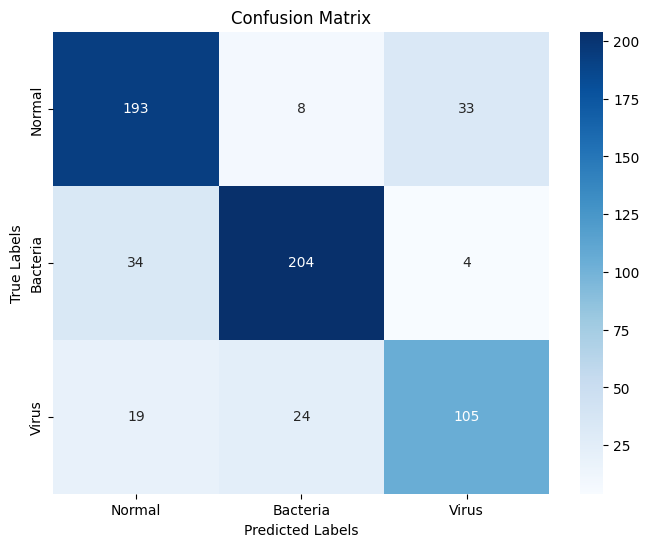

In [ ]:
# Get true labels and predictions
y_true = test_df[['Normal', 'Bacteria', 'Virus']].values.argmax(axis=1)  # Access labels from your DataFrame
y_pred = cnn.predict(test_set, steps=len(test_set), verbose=1)  # Predictions from the model


# Convert predictions to the class with the highest probability
y_true = test_df[['Normal', 'Bacteria', 'Virus']].values.argmax(axis=1)  # Access labels from your DataFrame
y_pred = cnn.predict(test_set, steps=len(test_set), verbose=1)  # Predictions from the model


# Convert predictions to the class with the highest probability
y_pred = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ['Normal', 'Bacteria', 'Virus']  # Define class names explicitly

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



So, our model is performing in a descent fashion. 

Here are our **Key Insights:**
**Class 0:**
* Precision = 0.78
* Recall = 0.82
* F1-Score = 0.80
* Support = 234

**Class 1:**
* Precision = 0.86
* Recall = 0.84
* F1-Score = 0.85
* Support = 242

**Class 2:**
* Precision = 0.74
* Recall = 0.71
* F1-Score = 0.72
* Support = 148

Overall accuracy is 0.80, meaning that the model correctly classified 80% of the instances. The macro average gives an equal weight to each class, while the weighted average takes the class distribution into account, which, in this case, results in values closer to the overall accuracy. Plus, it is struggling a bit to make the Class 2 (Virus) predictions.


Given these insights, let's try something else to see if we can improve our model. 

In this case, we'll use a pretarined model and see how that goes. 


## Using pretrained model.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
# **Step 1: Data Augmentation**
# Define the data augmentation strategy
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifting
    height_shift_range=0.2,  # Vertical shifting
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Filling in missing pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# Apply the data generators
# Making train data set
train_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train',  # Updated path
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5216 images belonging to 3 classes.


In [22]:
# Making test data set
test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test',  # Updated path
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 624 images belonging to 3 classes.


In [23]:
# **Step 2: Using Pretrained Model (VGG16)**
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(include_top=False, input_shape=(150, 150, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [24]:
# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False


In [25]:

# Add custom layers for classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  # 3 classes: Normal, Bacteria, Virus

# Define the model
model = Model(inputs=base_model.input, outputs=x)


In [26]:
# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model to see the architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,763,779 (60.13 MB)

 Trainable params: 1,049,091 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
# **Step 3: Class Weights Calculation**
# Get the class labels from the train set
class_labels = train_set.classes

# Compute the class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)


In [29]:
# **Step 4: Early Stopping and Model Checkpoint**
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with class weights and callbacks
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=25,
    class_weight={i: class_weights[i] for i in range(3)},
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.6626 - loss: 0.6978

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 652ms/step - accuracy: 0.6627 - loss: 0.6978 - val_accuracy: 0.2468 - val_loss: 2.4683
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.7037 - loss: 0.6616 - val_accuracy: 0.2244 - val_loss: 2.5386
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 620ms/step - accuracy: 0.7096 - loss: 0.6267 - val_accuracy: 0.2228 - val_loss: 2.8318
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 590ms/step - accuracy: 0.7215 - loss: 0.5976 - val_accuracy: 0.2228 - val_loss: 2.7941
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.7277 - loss: 0.6060 - val_accuracy: 0.2228 - val_loss: 3.0219
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.7260 - loss: 0.6025 - val_accuracy: 0.2228 - val_loss: 2.9740


In [ ]:

# **Step 5: Evaluating Model on Test Set**
# Evaluate the model on the test set using the correct generator
test_loss, test_accuracy = model.evaluate(test_set)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.8898 - loss: 0.3909
Test Loss: 0.4294814467430115
Test Accuracy: 0.8766025900840759



Fantastic news for our model!
The Test Performance indicates the following:

**Test Loss:** 0.3909 indicates the average error (how off the model's predictions were compared to the true values) on the test dataset. A lower loss is generally good, so this seems pretty solid.

**Test Accuracy:** 88.89% shows that the model performs well on unseen data, correctly predicting the label about 87% of the time. This is a significant improvement compared to the training and validation metrics showed earlier, which suggests that the model is generalizing better.

In conclusion, model did better, so so far so good. 😁

In [ ]:
# Access labels directly from the test set (as class indices)
y_true = test_df[['Normal', 'Bacteria', 'Virus']].values.argmax(axis=1)

# Predictions from the model
y_pred = model.predict(test_set, steps=len(test_set), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step


In [ ]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       234
           1       0.89      0.94      0.92       242
           2       0.80      0.80      0.80       148

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



The precision and recall values for classes 0 and 1 are decent but could be improved, especially for class 2. Since this is a pretrained model we can assume that there is insufficient data for class 2, which is the Virus caused pneumonia. Our key insights are the following:


**Class 0 (Normal):**

* Precision: 0.91
* Recall: 0.86
* F1-Score: 0.88
**Good performance, but there's a slight drop in recall, meaning there are some false negatives for this class.*

**Class 1 (Bacteria):**

* Precision: 0.89
* Recall: 0.94
* F1-Score: 0.92
**Very strong performance, with high recall indicating the model is good at identifying bacteria images.*

**Class 2 (Virus):**

* Precision: 0.80
* Recall: 0.80
* F1-Score: 0.80
**Lower performance compared to others, especially in recall. There may be some confusion in detecting viral images.*

**Overall Metrics:**
Accuracy: 0.88 (88%): A solid accuracy for the model on the test set.
Macro Average: 0.87: Average performance across classes without considering class imbalance.
Weighted Average: 0.88: The average performance weighted by the number of samples in each class.

**Conclusion:**
The model is performing quite well, especially on the Bacteria class, but it could potentially be improved for the Virus class.

These results have yielded a lot better than our previous ones for sure! 😀

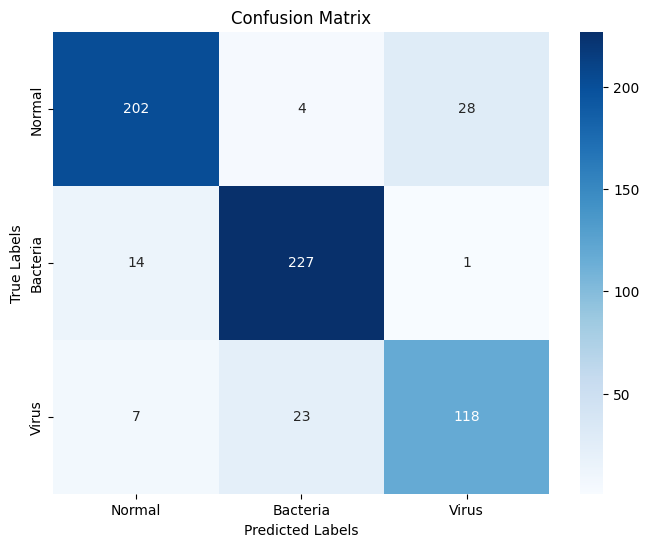

In [ ]:
# **Step 6: Building a Confusion Matrix**
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names
class_names = ['Normal', 'Bacteria', 'Virus']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# **Step 7: Saving the Model**
# Save the model for future use
model.save('pneumonia_model.h5')


In [ ]:
# To load the saved model later
model = load_model('pneumonia_model.h5')

In [ ]:
# **Step 8: Making Predictions on New Images (Example--I'll be using the images frorm our dataset since I don't have more images )**
# Make a single prediction on a new image
test_image_path = '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
test_image = image.load_img(test_image_path, target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


In [ ]:

# Map predictions back to classes
class_names = ['Normal', 'Bacteria', 'Virus']
prediction = class_names[np.argmax(result)]
print(f"Prediction for image {test_image_path}: {prediction}")

Prediction for image /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0001-0001.jpeg: Normal


In [ ]:
# Make a single prediction on a new image
test_image_path = '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_475.jpeg'
test_image = image.load_img(test_image_path, target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [ ]:
prediction = class_names[np.argmax(result)]
print(f"Prediction for image {test_image_path}: {prediction}")

Prediction for image /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_475.jpeg: Bacteria


In [ ]:
# Make a single prediction on a new image
test_image_path = '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_480.jpeg'
test_image = image.load_img(test_image_path, target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
prediction = class_names[np.argmax(result)]
print(f"Prediction for image {test_image_path}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for image /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_480.jpeg: Normal


In [ ]:
# Make a single prediction on a new image
test_image_path = '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0010-0001.jpeg'
test_image = image.load_img(test_image_path, target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
prediction = class_names[np.argmax(result)]
print(f"Prediction for image {test_image_path}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction for image /content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0010-0001.jpeg: Normal


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


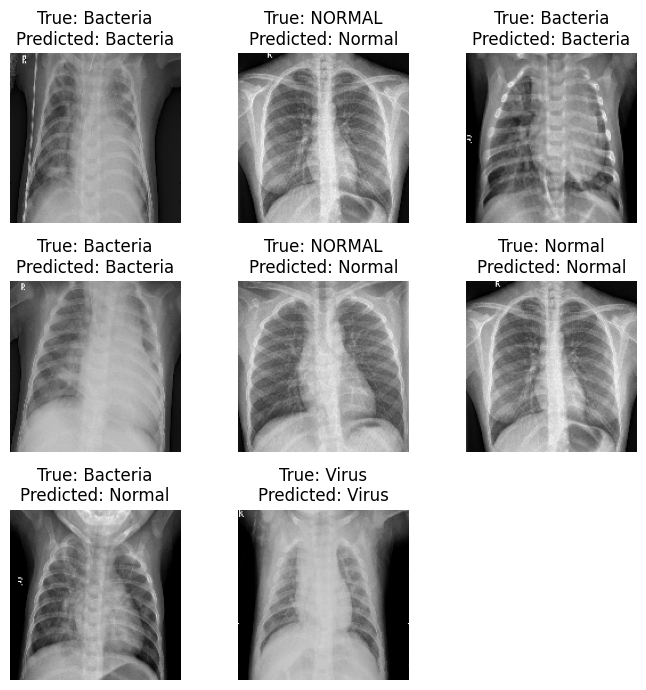

Image 1 - True: Bacteria, Predicted: Bacteria
Image 2 - True: NORMAL, Predicted: Normal
Image 3 - True: Bacteria, Predicted: Bacteria
Image 4 - True: Bacteria, Predicted: Bacteria
Image 5 - True: NORMAL, Predicted: Normal
Image 6 - True: Normal, Predicted: Normal
Image 7 - True: Bacteria, Predicted: Normal
Image 8 - True: Virus, Predicted: Virus


In [ ]:
# Making predictions
test_image_paths = [
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person111_bacteria_533.jpeg',
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0013-0001.jpeg',
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person100_bacteria_475.jpeg',
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person113_bacteria_542.jpeg',
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0006-0001.jpeg',
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/NORMAL/IM-0013-0001.jpeg',
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test/Bacteria/person119_bacteria_567.jpeg',
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train/2_Virus/person1018_virus_1706.jpeg'
]

true_labels = ['Bacteria', 'NORMAL', 'Bacteria', 'Bacteria', 'NORMAL', 'Normal', 'Bacteria', 'Virus']  # True labels for the 7 images plus one
predicted_labels = []

# Plotting setup
plt.figure(figsize=(7, 7))

for i, test_image_path in enumerate(test_image_paths):
    # Load and preprocess the image
    test_image = image.load_img(test_image_path, target_size=(150, 150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension

    # Predict the class
    result = model.predict(test_image)
    prediction = class_names[np.argmax(result)]  # Get class name from prediction

    predicted_labels.append(prediction)

    # Plot the image and display the true and predicted labels
    plt.subplot(3, 3, i+1)  # Create subplots for better visualization
    plt.imshow(test_image[0].astype('uint8'))
    plt.title(f"True: {true_labels[i]}\nPredicted: {prediction}")
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# Print all predictions at the end
for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)):
    print(f"Image {i+1} - True: {true}, Predicted: {pred}")


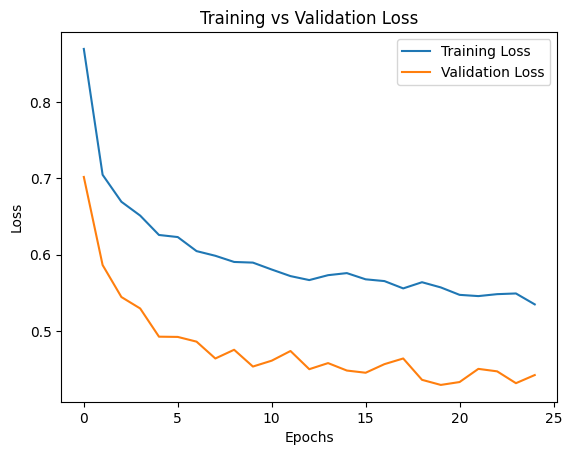

In [ ]:
# **Step 9: Evaluating the Model with Different Metrics**
# You can also visualize the training history to analyze performance.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

Can you picture what's going on here? If not I hope the following example can make this part much more comprehensive.

😊 Imagine you're training for a race 🏃‍♂️, and you have two different ways to track your progress:

1. **Training Loss** 📊: This is like tracking your **effort** in practice sessions. At first, you might be making lots of mistakes, but as you practice more, you get better. Your effort (or loss) goes down over time as you improve in training.

2. **Validation Loss** 🎯: This is like **testing your progress** in a simulated race. It's not during practice, but a test to see how well you're performing in a real scenario. You want to improve in the test as well as in practice.

### Here's how the graph looks:
- **Training Loss** 📉: Starts high, then steadily **decreases** as the model learns and gets better.
- **Validation Loss** 🔴: It might follow a similar trend at first, but then could **start going up** after a while, showing that the model is getting too focused on the training data and not generalizing well to the test data.

### Key Points:
- If both lines go down together, that's great! 😎 You’re improving both in training and in real tests.
- If the **training loss** goes down but the **validation loss** starts to go up, that’s a sign that your model is **overfitting** — it’s getting too good at memorizing the training data and not doing well on new, unseen data. 🚫

So, in a nutshell:
- **Training loss** = How well you're doing in practice 🏋️‍♂️
- **Validation loss** = How well you're doing in the actual test 🏁

The goal is to have both lines go down together! 👏

In our case, our Training loss did go down without having any noticeable peaks, however our Validation Loss did present some peaks, and this could be in part, due to class 2 not being very well predicted by our model.

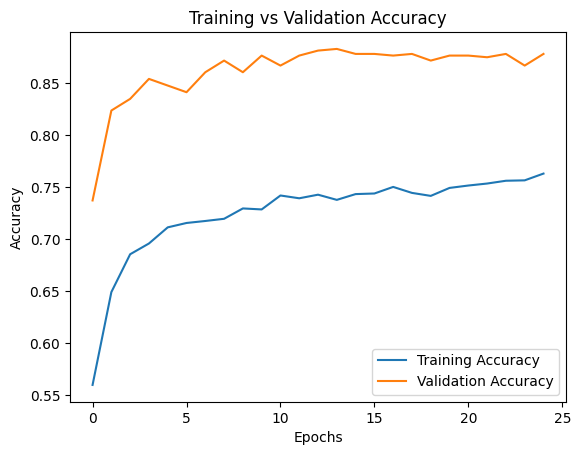

In [ ]:
# Plot accuracy for training and validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

So what's ging on here? What are we seeing?


Imagine you're taking a quiz 📝, and you're measuring how well you do in two ways:

1. **Training Accuracy** 🎓: This shows how well you're doing in **practice sessions**. In the beginning, you're still figuring things out, so you might not get many answers right. But as you keep practicing, your score (accuracy) goes up. 👍

2. **Validation Accuracy** 🌟: This shows how well you're doing in the **real test**. It's not practice anymore, but a real challenge where you're being tested on things you haven’t seen during practice. You want to do well here too!

How the graph might look:
- **Training Accuracy** 📈: It starts low, but as the model gets better, it keeps going **up** because it’s learning from the practice data.
- **Validation Accuracy** 🌍: At first, it might go up as well, but if the model starts to overfit, it could **level off** or even start going **down** because it’s not generalizing well to the unseen test data.

Here are some Key Points to help wrap our heads around this:
- If both **training** and **validation accuracy** go up together, that's a win! We're improving on both practice and real tests. 🎯👏
- If **training accuracy** keeps increasing but **validation accuracy** starts to drop, it means the model is **overfitting**, in other words, – it’s getting too good at the practice data and struggling to handle new challenges. 😬

So in simple terms:
- **Training Accuracy** = How well you're doing in practice 🏋️‍♀️
- **Validation Accuracy** = How well you're doing in the real test 🏆

Ideally, we want both lines to **increase** together, as we want to be acing both practice and the real test! ✨

In our case, the model is really not overfitting, so that's a win! But we kind of knew by the previous metrics that this wouldn't be the case. I still wanted to make this test though so you can have the code in case you want to check this metric.

# Improving our model

In [ ]:
## Adding Dropout

"""Dropout helps prevent the model from relying too much on specific neurons by randomly "dropping" a proportion of them during training.
This forces the network to learn redundant representations, making the model more robust and able to generalize better to unseen data."""


# Define the model with Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after the first Conv2D layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after the second Conv2D layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout after the dense layer
    Dense(3, activation='softmax')  # Output layer
])

# Compile the model with an optimizer and metrics
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',  # Using sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

# Summary of the model
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,739 (40.58 MB)

 Trainable params: 10,636,739 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Use ImageDataGenerator with arrays, you can:
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling images
validation_datagen = ImageDataGenerator(rescale=1./255)

# Convert them to a flow generator:
# train_generator = train_datagen.flow(train_set[0], train_set[1], batch_size=32) #This was causing the error
# validation_generator = validation_datagen.flow(validation_set[0], validation_set[1], batch_size=32) #This was causing the error
train_generator = train_datagen.flow_from_directory( #Using flow_from_directory, which is the correct way of using the ImageDataGenerator class with folder structured data.
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Assuming 'categorical' for one-hot encoded labels
)
validation_generator = validation_datagen.flow_from_directory(#Using flow_from_directory, which is the correct way of using the ImageDataGenerator class with folder structured data.
    '/content/drive/MyDrive/Pneumonia_Project/archive_2/chest_xray/test', #Using test_set as it's likely what the user intended, as 'validation_set' is not defined
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Assuming 'categorical' for one-hot encoded labels
)
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',  # Use categorical_crossentropy
              metrics=['accuracy'])

# Proceed with training as before:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Calculate steps_per_epoch
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Calculate validation_steps
)


Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 514ms/step - accuracy: 0.5403 - loss: 1.4830 - val_accuracy: 0.2812 - val_loss: 2.1962
Epoch 2/10
 46/163 ━━━━━━━━━━━━━━━━━━━━ 50s 430ms/step - accuracy: 0.7682 - loss: 0.5647

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 422ms/step - accuracy: 0.8631 - loss: 0.2997 - val_accuracy: 0.6678 - val_loss: 2.0904
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 414ms/step - accuracy: 0.8883 - loss: 0.2497 - val_accuracy: 0.6645 - val_loss: 1.9691
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.9009 - loss: 0.2261 - val_accuracy: 0.6645 - val_loss: 1.9798
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 413ms/step - accuracy: 0.9017 - loss: 0.2250 - val_accuracy: 0.6266 - val_loss: 2.3229
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 779ms/step - accuracy: 0.9074 - loss: 0.2046 - val_accuracy: 0.6562 - val_loss: 2.2377
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 413ms/step - accuracy: 0.9247 - loss: 0.1757 - val_accuracy: 0.6332 - val_loss: 2.9205
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 415ms/step - accuracy: 0.9281 - loss: 0.1782 - val_accuracy: 0.6628 - val_loss: 2.2950
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 414ms/step - accuracy: 0.9250 - loss: 

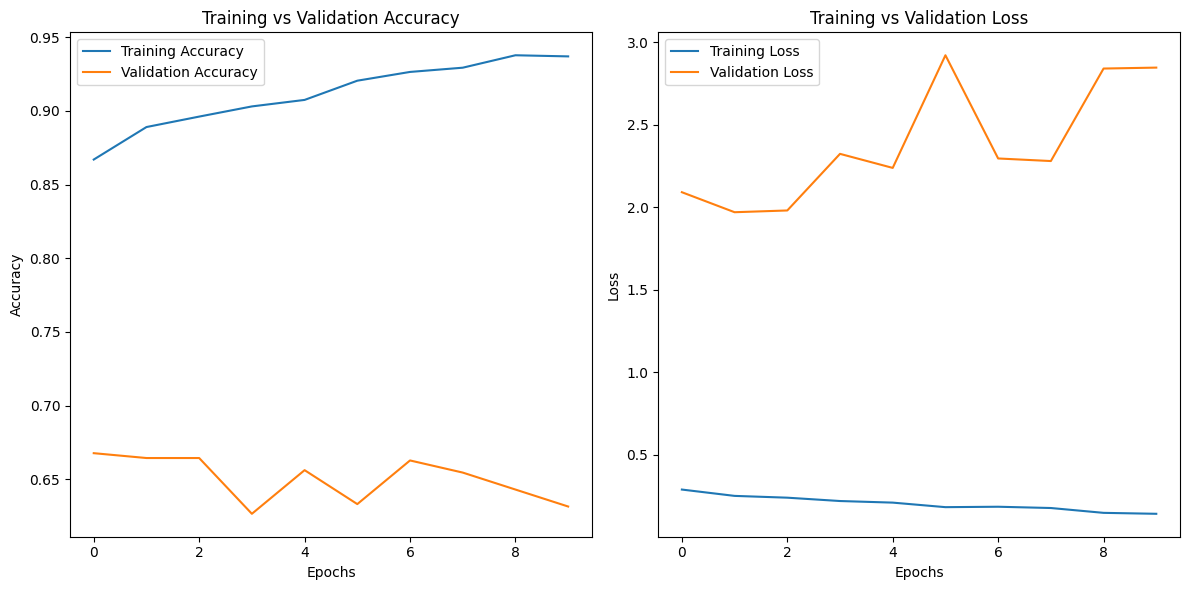

In [ ]:
# Plotting training & validation accuracy and loss

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


in our partucular case, dropout technique doesn't seem to help our model. I had a feeling it wouldn't but I still wntd to try nontheless. 

I will leave the next steps marked down so I can come back and keep on improving the model. I will also leave them there in case you want to explore a bit more.

## Hyperparameter Tuning

In [ ]:
# Required imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

# Load VGG16 base model (pre-trained, excluding the top)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Fine-tune by unfreezing a few layers
for layer in base_model.layers[:-4]:  # Freeze most layers
    layer.trainable = False
for layer in base_model.layers[-4:]:  # Unfreeze last few layers
    layer.trainable = True

# Build the model (Including dropout and L2 regularization)
model = Sequential([
    base_model,  # Add VGG16 base model
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.5],  # Add brightness augmentation
    channel_shift_range=30.0     # Add color channel shift
)

# Data generator for test/validation set (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the generators (you should have the paths to your data folders)
train_set = train_datagen.flow_from_directory(
    'path_to_train_directory',  # Replace with your actual train directory path
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    'path_to_test_directory',  # Replace with your actual test directory path
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=25,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions and classification report
from sklearn.metrics import classification_report
import numpy as np

# Get true labels from the test set (if available as ground truth)
y_true = test_set.classes  # Use the correct method to access true labels

# Predict using the model
y_pred = model.predict(test_set, steps=len(test_set), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_true, y_pred))

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate a confusion matrix (for detailed evaluation)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Bacteria', 'Virus']  # Modify as per your class names

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the model for later use
model.save('fine_tuned_pneumonia_model.h5')


## Cross-Validation


In [ ]:
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load VGG16 base model (pre-trained, excluding the top)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Fine-tune by unfreezing a few layers
for layer in base_model.layers[:-4]:  # Freeze most layers
    layer.trainable = False
for layer in base_model.layers[-4:]:  # Unfreeze last few layers
    layer.trainable = True

# Build the model (including dropout and L2 regularization)
def build_model():
    model = Sequential([
        base_model,  # Add VGG16 base model
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Output layer (3 classes)
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation settings
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
fold_no = 1
cv_loss = []
cv_accuracy = []

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.5],  # Add brightness augmentation
    channel_shift_range=30.0     # Add color channel shift
)

test_datagen = ImageDataGenerator(rescale=1./255)

# For each fold, train and evaluate the model
for train_idx, val_idx in skf.split(X_train, y_train):
    print(f"Training fold {fold_no}/{num_folds}...")

    # Split data into train and validation based on current fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Load the previously saved fine-tuned model
    model = load_model('fine_tuned_pneumonia_model.h5')

    # Set up early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

    # Set up data generators for this fold
    train_generator = train_datagen.flow(X_train_fold, y_train_fold, batch_size=32)
    val_generator = test_datagen.flow(X_val_fold, y_val_fold, batch_size=32)

    # Train the model (further tweaking the pre-trained model)
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluate the model on the validation set for this fold
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
    print(f"Fold {fold_no} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")

    # Save results of the current fold
    cv_loss.append(val_loss)
    cv_accuracy.append(val_accuracy)

    fold_no += 1

# After all folds are completed, print average performance across all folds
print(f"Average Cross-Validation Loss: {np.mean(cv_loss)}")
print(f"Average Cross-Validation Accuracy: {np.mean(cv_accuracy)}")

# Optionally, you can save the final model after all folds are complete
final_model = model  # You can choose to save the final model after the last fold
final_model.save('final_fine_tuned_pneumonia_model.h5')
print("Final model saved as 'final_fine_tuned_pneumonia_model.h5'")

# Example of model loading for final evaluation
# To load the final model (after cross-validation) for further evaluation or prediction:
# final_model = load_model('final_fine_tuned_pneumonia_model.h5')

# Generate predictions and classification report for final model
y_true = test_set.classes  # Use the correct method to access true labels
y_pred = final_model.predict(test_set, steps=len(test_set), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_true, y_pred))

# Generate confusion matrix for detailed evaluation
cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Bacteria', 'Virus']  # Modify as per your class names

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Model Interpretability

Might be worth it understanding how is our model making decision. Grad-CAM (Gradient-weighted Class Activation Mapping) is a good statrting point since it allows us to visualize which regions of the input image contribute most to the decision.

In [ ]:
gradcam = Gradcam(cnn)

# Get heatmap for the first image in the validation set
img = validation_generator[0][0][0]  # Sample image
heatmap = gradcam.score([img])

# Visualize the heatmap
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.show()


In [ ]:
# Save the model
cnn.save('pneumonia_model.h5')


In [ ]:
# To load the saved model
cnn = load_model('pneumonia_model.h5')

# Now our model is ready to be tested in unseen data.

## Final thoughts

After all the hard work, it’s amazing to see that our model is up and running! 😎 That’s something to be proud of, but why is this project so relevant? The answer is simple: even in 2025, pneumonia remains a major global health issue. It’s one of the leading causes of death, especially among young children, the elderly, and immunocompromised individuals. Early and accurate diagnosis can save lives, but traditional methods like chest X-rays and CT scans can be time-consuming and prone to human error.

**Pneumonia's Global Impact:**

Child Mortality: Pneumonia is the #1 infectious cause of death for children under 5 worldwide. In 2019 alone, it claimed the lives of 740,180 kids, which was 14% of all deaths in that age group. 💔 (WHO, -https://www.who.int/news-room/fact-sheets/detail/pneumonia?utm_source-)

Overall Mortality: In 2019, pneumonia led to about 2.5 million deaths globally, including 672,000 children. 😔 (GoldCOPD, https://goldcopd.org/world-pneumonia-day/?utm_source)

Challenges in Diagnosis:

Diagnostic Accuracy: Studies show that clinicians often overestimate the likelihood of pneumonia before radiology results. In fact, 95% of positive diagnoses were overestimated! 🧐 (JAMA, https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2778364?utm_source)

Emergency Department Diagnoses: A study found that 74% of patients diagnosed with pneumonia in the ER had a correct diagnosis, but 18% were misdiagnosed. 🤦‍♂️ (JAMA, https://pubmed.ncbi.nlm.nih.gov/21855251/)

These statistics highlight the urgent need for accurate and timely diagnoses to reduce mortality, especially for vulnerable populations. Luckily, machine learning and deep learning are here to help improve diagnostic accuracy and assist healthcare professionals in making informed decisions.

This project could contribute to a healthcare revolution, especially in areas with a shortage of medical professionals. Pneumonia classification models could offer second opinions, help with triage, and assist remote medical settings. 🌍

So if you’re unsure whether to dive into your own model, just remember: your work could make a real difference in the world. Let’s keep pushing forward, because this could be just the start of something amazing! 🙌